In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from preprocessing import market_prepro

Now that we have Spencer's data importer lets make a driver that pulls in the data and training the model

SUDO CODE:

1. call data importer

2. restructure the dataset based on number of days desired [function written]

3. train model with training data

4. test model

5. return metrics

In [2]:
# st = "Stocks"
st = "ETFs"

#Input stock name
sn = "aadr" 
f = r'D:\Desktop\College Spring 2023\machineLearning\project\coding\data'
X_train, X_test, T_train, T_test = market_prepro(f,st,sn)

print(X_train.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1044 entries, 2010-07-21 to 2015-09-14
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              1044 non-null   float64
 1   High              1044 non-null   float64
 2   Low               1044 non-null   float64
 3   Volume            1044 non-null   float64
 4   High-Low          1044 non-null   float64
 5   Close-Open        1044 non-null   float64
 6   Day_date          1044 non-null   int32  
 7   Month             1044 non-null   int32  
 8   Year              1044 non-null   int32  
 9   near_end_quarter  1044 non-null   int64  
 10  Day               1044 non-null   int64  
dtypes: float64(6), int32(3), int64(2)
memory usage: 85.6 KB
None


In [39]:
def structure_timeseries_features(df,offset_back, offset_for,exclude):
    '''
    This takes a dataframe and creates new columns that contain the data from
    previous days so that time series forecasting can occur.

    INPUTS:
        df - dataframe: input data

        offset - int: the number of days to go back. This creates this many
                        new columns

        exclude - list str: list of columns to exclude from the time series 
                            expansion

    OUTPUTS:
        df_out - dataframe: dataframe with new columns
    '''

    df_out = pd.DataFrame() 

    for cc in df.columns.values:
        if (cc not in exclude):
            for ii in range(offset_back):
                col_name = (cc+"_m"+str(ii+1))

                df_out[col_name] = df[cc].shift(ii+1)


    df_out = df_out.iloc[offset_back:-offset_for,:]

    return df_out

def structure_timeseries_targets(df,offset_back, offset_for):
    '''
    companion function to remove the first few days of targets to make sure
    the sizes match between features and targets.

    INPUTS:
        df - dataframe: input data targets.

    OUTPUTS:
        df_out - dataframe: dataframe with rows removed

    '''
    # df_out = df.iloc[offset:]

    df_out = pd.DataFrame() 

    # for cc in df.columns.values:
    for ii in range(offset_for):
        col_name = (df.name+"_p"+str(ii))

        df_out[col_name] = df.shift(-(ii))


    df_out = df_out.iloc[offset_back:-offset_for,:]

    return df_out

# ff = X_train.copy()
# tt = T_train.copy()



# df_ff = structure_timeseries_features(ff,2,5, ['Day_date','Month','Year'])
# df_tt = structure_timeseries_targets(tt,2,5)


In [99]:
def modeldriver(mdl, n_days_back, n_days_for, f, st, sn):
    '''
    This function takes a model, imports the data, trains the model, and tests 
    the model

    INPUTS:
        mdl -  the model to test

        n_days_back - int: the number of days to go back to use as features

        n_days_for - int: the number of days to predict into the future

        f - str: filepath to the stock

        st - str: stock type

        sn - str: stock name
    OUTPUTS:
        NONE:
    '''

    exclude_col = ['Day_date','Month','Year']

    X_train, X_test, T_train, T_test = market_prepro(f,st,sn)

    X_train = structure_timeseries_features(X_train,
                                            n_days_back, 
                                            n_days_for, 
                                            exclude_col,
                                            )
    X_test = structure_timeseries_features(X_test,
                                           n_days_back, 
                                           n_days_for, 
                                           exclude_col,
                                           )
    T_train =  structure_timeseries_targets(T_train,
                                            n_days_back,
                                            n_days_for,
                                            )
    T_test =  structure_timeseries_targets(T_test,
                                            n_days_back,
                                            n_days_for,
                                            )
    
    data = {'X_train': X_train, 
            'X_test': X_test, 
            'T_train': T_train, 
            'T_test':T_test}
    

    mdl.fit(X_train,T_train)

    y_train = mdl.predict(X_train)
    y_test = mdl.predict(X_test)

    y_train = pd.DataFrame(y_train,
                           columns=T_train.columns.values,
                           index=T_train.index
                           )
    y_test = pd.DataFrame(y_test,
                          columns=T_test.columns.values,
                          index=T_test.index
                          )

    score_train = mdl.score(X_train,T_train)
    score_test = mdl.score(X_test,T_test)

    # print(score_train)
    # print(score_test)

    return y_train, y_test, data


In [101]:
from sklearn.linear_model import Ridge
from sklearn.metrics import (r2_score,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                            )

n_days_back = 5
n_days_for = 5

mdl_r = Ridge(alpha=0.01)

y_train, y_test, data_out = modeldriver(mdl_r, n_days_back, n_days_for, f, st, sn)



test_mae  = mean_absolute_error(data_out['T_test'],y_test)
test_mape = mean_absolute_percentage_error(data_out['T_test'],y_test)




(511, 5)


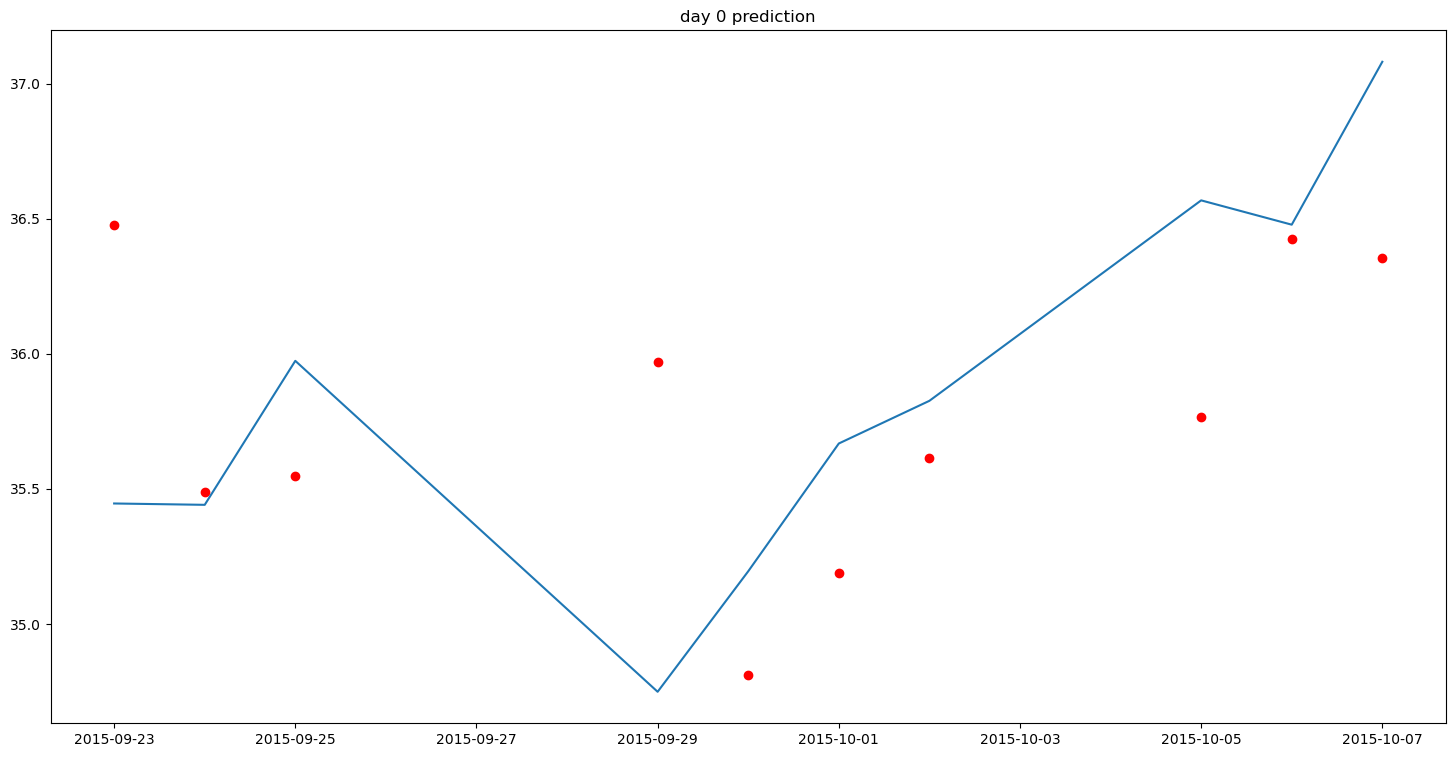

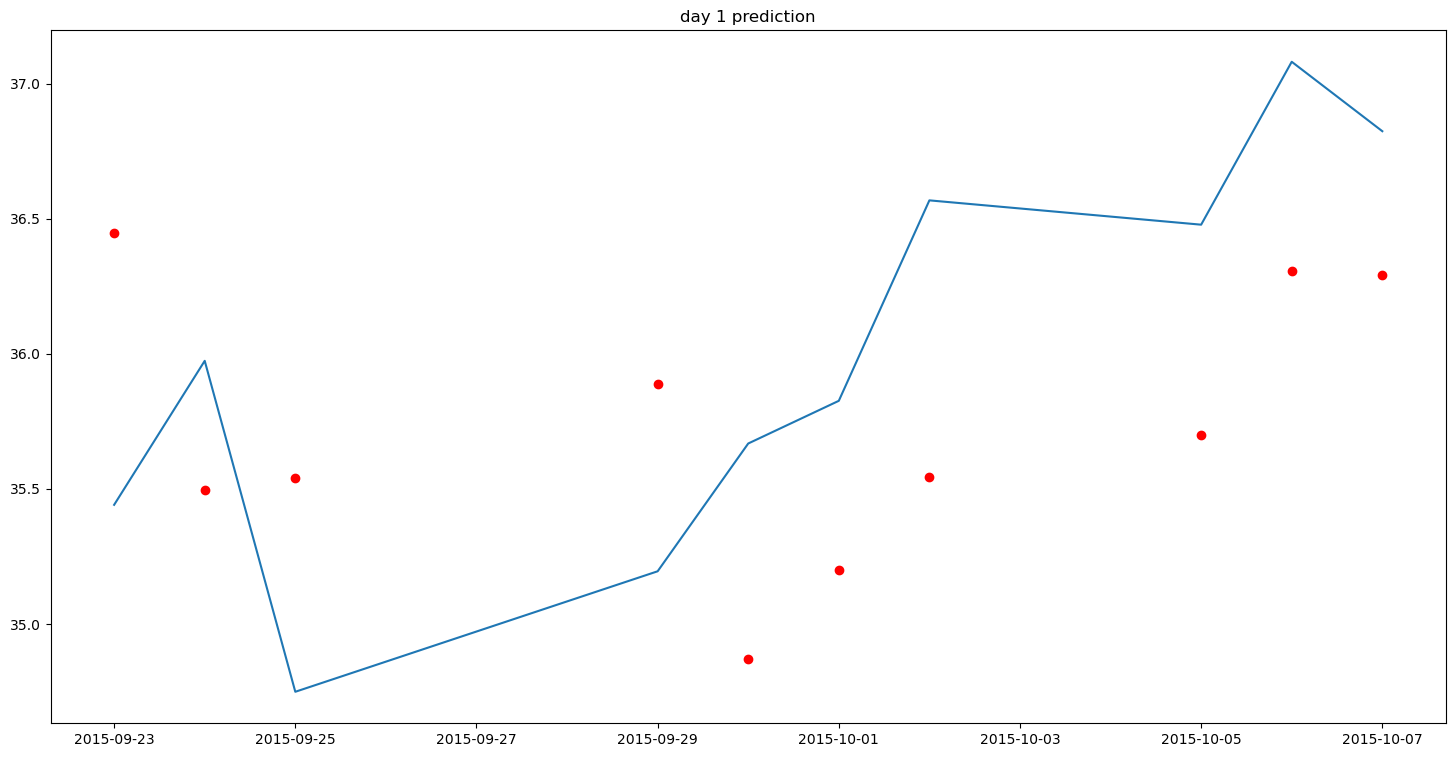

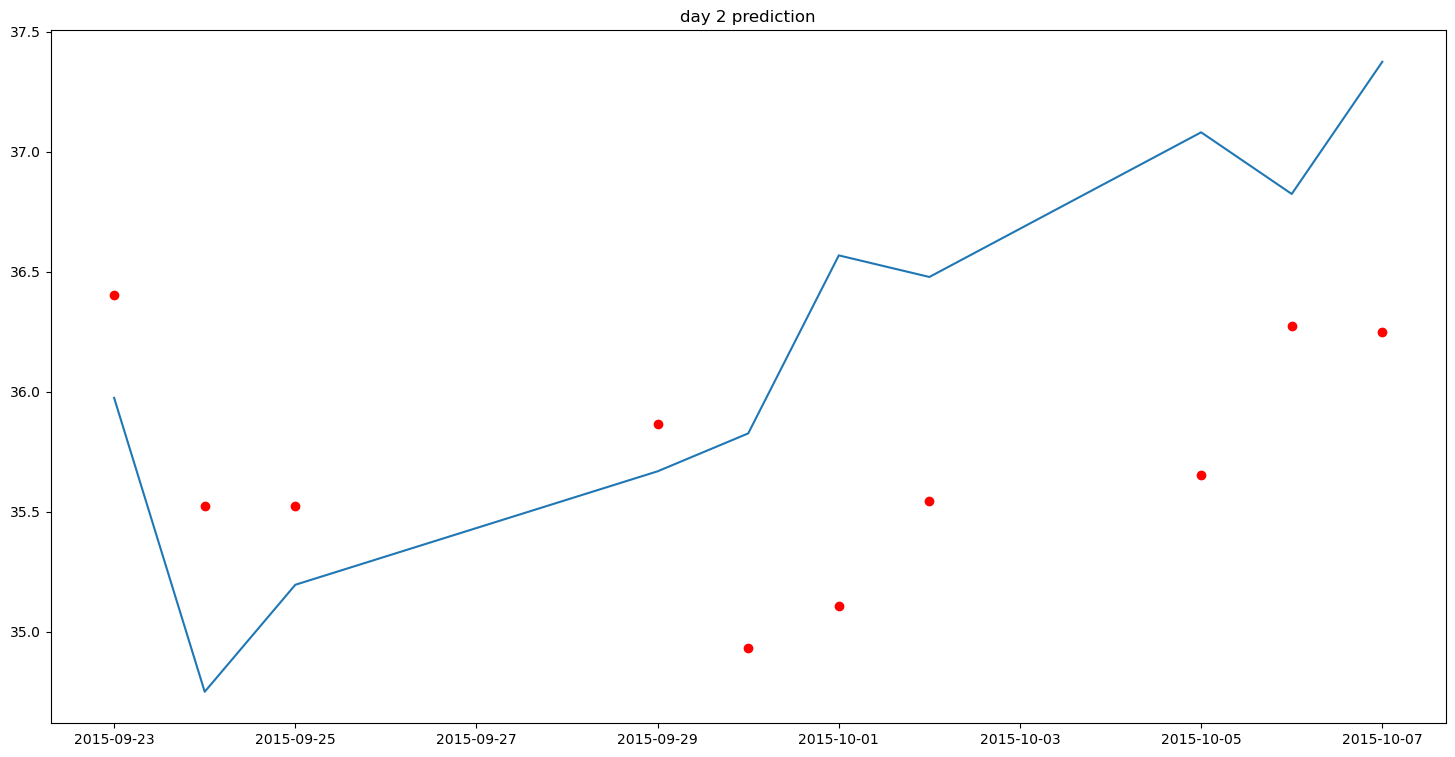

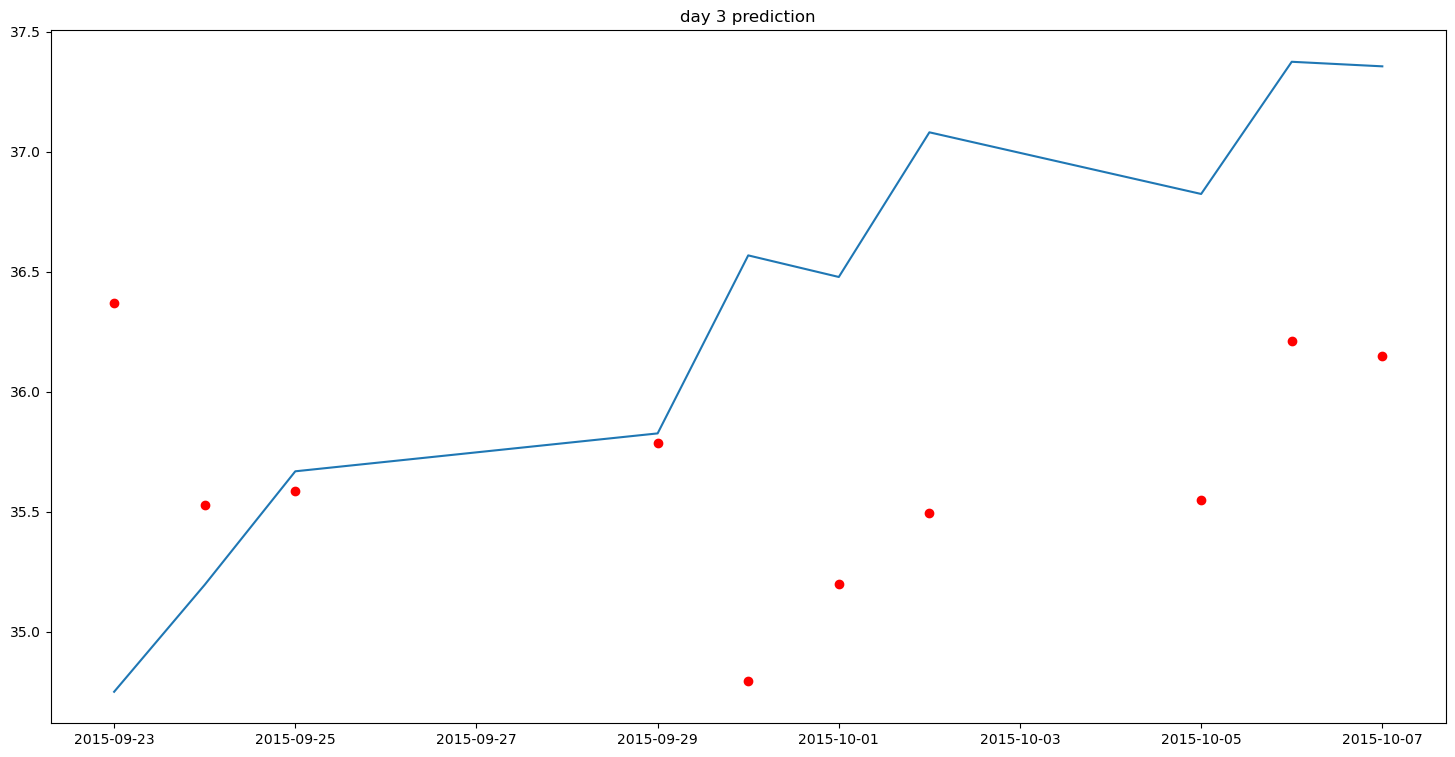

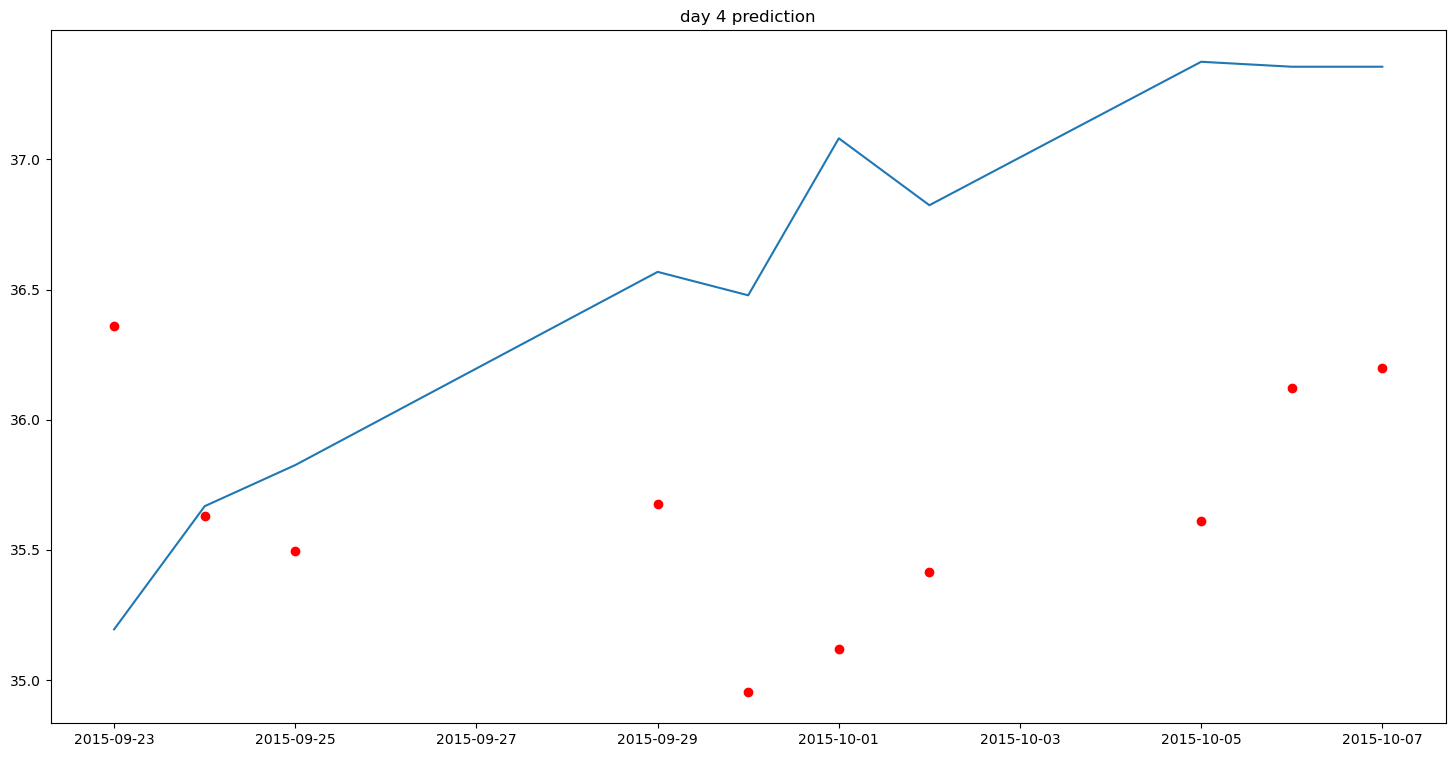

In [83]:
plotlen = 10

# x = range(0,len(data_out['T_test']))
x = range(0,plotlen)

print(np.shape(y_test))
for ii in range(0,np.shape(y_test)[1]):
    y_true = data_out['T_test'].iloc[0:plotlen,ii]


    plt.figure(figsize=(18,9))
    plt.plot(y_true.index,y_true,label='true')
    # plt.plot(x,y_test[0:plotlen],marker='o')
    plt.scatter(y_true.index,y_test[0:plotlen,ii],c='r')
    plt.title('day '+ str(ii) + ' prediction')

In [97]:
display(data_out['T_test'].head(10))

display(y_test.head(10))

,Close_p0,Close_p1,Close_p2,Close_p3,Close_p4
Date,,,,,
2015-09-23,35.446,35.441,35.974,34.749,35.195
2015-09-24,35.441,35.974,34.749,35.195,35.668
2015-09-25,35.974,34.749,35.195,35.668,35.826
2015-09-29,34.749,35.195,35.668,35.826,36.568
2015-09-30,35.195,35.668,35.826,36.568,36.478
2015-10-01,35.668,35.826,36.568,36.478,37.081
2015-10-02,35.826,36.568,36.478,37.081,36.824
2015-10-05,36.568,36.478,37.081,36.824,37.375
2015-10-06,36.478,37.081,36.824,37.375,37.356


,Close_p0,Close_p1,Close_p2,Close_p3,Close_p4
Date,,,,,
2015-09-23,36.475914,36.446766,36.402959,36.370313,36.360772
2015-09-24,35.487864,35.495717,35.521723,35.525934,35.629371
2015-09-25,35.546614,35.541512,35.522096,35.586349,35.495795
2015-09-29,35.968102,35.887068,35.867183,35.786375,35.677743
2015-09-30,34.810072,34.870602,34.931050,34.795716,34.955085
2015-10-01,35.187317,35.200514,35.105636,35.198693,35.119911
2015-10-02,35.614230,35.543352,35.542470,35.495313,35.415120
2015-10-05,35.766527,35.698789,35.654433,35.547639,35.609477
2015-10-06,36.424719,36.306213,36.273224,36.211109,36.122563


In [98]:
display(data_out['T_train'].head(10))

display(y_train.head(10))

,Close_p0,Close_p1,Close_p2,Close_p3,Close_p4
Date,,,,,
2010-07-28,24.431,24.256,24.333,24.839,25.042
2010-07-29,24.256,24.333,24.839,25.042,25.069
2010-07-30,24.333,24.839,25.042,25.069,25.118
2010-08-02,24.839,25.042,25.069,25.118,24.926
2010-08-03,25.042,25.069,25.118,24.926,25.265
2010-08-04,25.069,25.118,24.926,25.265,25.285
2010-08-05,25.118,24.926,25.265,25.285,24.401
2010-08-06,24.926,25.265,25.285,24.401,24.276
2010-08-09,25.265,25.285,24.401,24.276,24.401


,Close_p0,Close_p1,Close_p2,Close_p3,Close_p4
Date,,,,,
2010-07-28,24.507609,24.598047,24.695267,24.693561,24.700138
2010-07-29,24.483458,24.613551,24.691739,24.771396,24.797366
2010-07-30,24.366224,24.490457,24.631146,24.665287,24.711615
2010-08-02,24.399082,24.562095,24.545531,24.602783,24.619301
2010-08-03,24.873564,24.829086,24.875639,24.926857,24.892581
2010-08-04,24.977464,24.998247,25.038615,25.046658,25.177024
2010-08-05,25.086009,25.130090,25.145283,25.262764,25.284750
2010-08-06,25.147055,25.186887,25.283167,25.307745,25.396931
2010-08-09,24.984008,25.054463,25.018962,25.130300,25.163969
